In [138]:
import sklearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy import std
from collections import Counter
from numpy import mean
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split, cross_val_score, KFold, RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression, Lasso, RidgeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


# 从文本文件读取数据
with open('data.txt', 'r') as file:
    lines = file.readlines()
diabetes = pd.DataFrame()

# 逐行处理数据并添加到DataFrame
for line in lines:
    # 按空格分割每一行
    parts = line.strip().split()
    # 提取种类标签
    label = int(parts[0]) 
    # 提取特征和对应的值
    features = {}
    for part in parts[1:]:
        feature_number, feature_value = part.split(':')
        features[int(feature_number)] = float(feature_value)
    
    # 合并种类和特征，然后将其添加到DataFrame
    row_data = {'Label': label, **features}
    diabetes = diabetes.append(row_data, ignore_index=True)



In [132]:
diabetes = diabetes.dropna(subset=[1]) 
diabetes = diabetes.dropna(subset=[2]) 
diabetes = diabetes.dropna(subset=[3])
diabetes = diabetes.dropna(subset=[4]) 
diabetes = diabetes.dropna(subset=[5]) 
diabetes = diabetes.dropna(subset=[6]) 
diabetes = diabetes.dropna(subset=[7]) 
diabetes = diabetes.dropna(subset=[8]) 

In [128]:
import numpy as np

class Perceptron:
    def __init__(self, input_size, learning_rate, epochs):
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.weights = np.zeros(input_size + 1)  # Additional weight for the bias
        self.history = []

    def predict(self, inputs):
        summation = np.dot(inputs, self.weights[1:]) + self.weights[0]
        return 1 if summation > 0 else -1

    def train(self, training_data, labels):
        for _ in range(self.epochs):
            errors = 0
            for inputs, label in zip(training_data, labels):
                prediction = self.predict(inputs)
                update = self.learning_rate * (label - prediction)
                self.weights[1:] += update * inputs
                self.weights[0] += update
                errors += int(update != 0)
            self.history.append(errors)



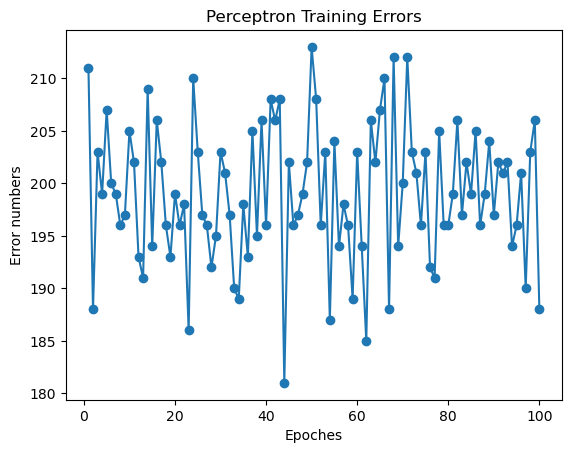

              precision    recall  f1-score   support

    diabetes       0.88      0.15      0.25        47
non-diabetes       0.72      0.99      0.84       105

    accuracy                           0.73       152
   macro avg       0.80      0.57      0.54       152
weighted avg       0.77      0.73      0.66       152



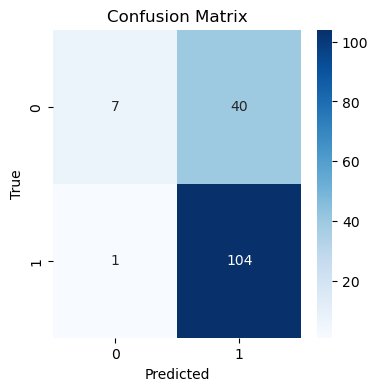

In [133]:
          
if __name__ == '__main__':

    # 划分特征和标签
    X = diabetes[[1,2,3,4,5,6,7,8]]
    X=X.values
    y = diabetes['Label'] 
    y= y.values
    # 划分训练集和测试集
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    y_pred=[ ]
    perceptron = Perceptron(input_size=8, learning_rate=0.1,epochs=100)
    perceptron.train(X_train,y_train)
    for inputs in X_test:
        prediction = perceptron.predict(inputs)
        y_pred.append(prediction)
         
    plt.plot(range(1, len(perceptron.history) + 1), perceptron.history, marker = 'o')
    plt.xlabel('Epoches')
    plt.ylabel('Error numbers')
    plt.title('Perceptron Training Errors')
    plt.show()
    print(classification_report(y_test, y_pred, target_names=['diabetes', 'non-diabetes' ]))
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# 计算混淆矩阵
conf_matrix = confusion_matrix(y_test, y_pred)

# 可视化混淆矩阵
plt.figure(figsize=(4, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [85]:
class MultilayerPerceptron:
    def __init__(self, input_size, hidden_size, output_size, learning_rate=0.01, epochs=100):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.learning_rate = learning_rate
        self.epochs = epochs
        
        # 初始化权重和偏置
        self.weights_input_hidden = np.random.rand(self.input_size, self.hidden_size)
        self.bias_hidden = np.zeros(self.hidden_size)
        self.weights_hidden_output = np.random.rand(self.hidden_size, self.output_size)
        self.bias_output = np.zeros(self.output_size)
        
    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))
    
    def sigmoid_derivative(self, x):
        return x * (1 - x)
    
    def forward(self, inputs):
        self.hidden_layer_input = np.dot(inputs, self.weights_input_hidden) + self.bias_hidden
        self.hidden_layer_output = self.sigmoid(self.hidden_layer_input)
        self.output_layer_input = np.dot(self.hidden_layer_output, self.weights_hidden_output) + self.bias_output
        self.output_layer_output = self.sigmoid(self.output_layer_input)
        
        return 1 if self.output_layer_output > 0.5 else -1
    
    def train(self, training_data, labels):
        for epoch in range(self.epochs):
            for inputs, label in zip(training_data, labels):
                # 前向传播
                self.forward(inputs)
                
                # 反向传播
                error = label - self.output_layer_output
                output_delta = error * self.sigmoid_derivative(self.output_layer_output)
                
                hidden_layer_error = output_delta.dot(self.weights_hidden_output.T)
                hidden_layer_delta = hidden_layer_error * self.sigmoid_derivative(self.hidden_layer_output)
                
                # 更新权重和偏置
                self.weights_hidden_output += self.hidden_layer_output.reshape(-1, 1) * output_delta * self.learning_rate
                self.bias_output += output_delta * self.learning_rate
                self.weights_input_hidden += inputs.reshape(-1, 1) * hidden_layer_delta * self.learning_rate
                self.bias_hidden += hidden_layer_delta * self.learning_rate

if __name__ == "__main__":


    # 创建MLP
    input_size = 8
    hidden_size = 32
    output_size = 1
    mlp = MultilayerPerceptron(input_size, hidden_size, output_size)

    # 训练MLP
    mlp.train(X_train,y_train)

    # 测试MLP
    y_pred=[ ]
    for inputs in X_test:
        prediction =  mlp.forward(inputs)
        y_pred.append(prediction)

    print(classification_report(y_test, y_pred, target_names=['diabetes', 'non-diabetes' ]))

              precision    recall  f1-score   support

    diabetes       0.50      0.91      0.65        47
non-diabetes       0.94      0.59      0.73       105

    accuracy                           0.69       152
   macro avg       0.72      0.75      0.69       152
weighted avg       0.80      0.69      0.70       152



In [134]:
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

 

# 定义Keras模型的函数
def create_model(hidden_units=32, learning_rate=0.01, activation='relu'):
    model = Sequential()
    model.add(Dense(hidden_units, input_dim=8, activation=activation))
    model.add(Dense(hidden_units,  activation=activation))
    model.add(Dense(hidden_units,  activation=activation))
    model.add(Dense(1, activation='sigmoid'))
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(loss='mse', optimizer=optimizer, metrics=['accuracy'])
    return model

# 创建KerasClassifier包装的模型
model = KerasClassifier(build_fn=create_model, verbose=0)

# 定义参数网格
param_grid = {
    'hidden_units': [32, 128, 256],
    'learning_rate': [0.01, 0.1, 0.001],
    'activation': ['relu', 'tanh', 'sigmoid']
}

# 创建GridSearchCV对象
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, verbose=1, n_jobs=-1)

# 执行网格搜索
grid_result = grid.fit(X_train, y_train)

# 输出最佳参数和得分
print("Best parameters found: ", grid_result.best_params_)
print("Best accuracy found: ", grid_result.best_score_)

# 评估模型性能
best_model = grid_result.best_estimator_
test_accuracy = best_model.score(X_test, y_test)
print("Test accuracy of the best model: ", test_accuracy)


Fitting 3 folds for each of 27 candidates, totalling 81 fits
Best parameters found:  {'activation': 'relu', 'hidden_units': 256, 'learning_rate': 0.01}
Best accuracy found:  0.7478986779848734
Test accuracy of the best model:  0.8026315569877625


In [ ]:
# 记录损失值的列表
loss_history = []

# 训练模型并记录损失值
num_epochs = 50
for epoch in range(num_epochs):
    history = model.fit(X_train, y_train, epochs=1, verbose=0)
    loss_history.append(history.history['loss'][0])

# 可视化损失函数的迭代过程
plt.plot(np.arange(1, num_epochs + 1), loss_history, marker='o', linestyle='-')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('MLP Training Loss')
plt.grid(True)
plt.show()
# 进行预测
y_pred = model.predict(X_test) 
 # 选择max值进行输出0,或1
y_pred  = np.where(y_pred  >= 0.5, 1, y_pred )
y_pred  = np.where(y_pred  < 0.5, -1, y_pred )

print(classification_report(y_test, y_pred, target_names=['non-diabetes', 'diabetes' ]))

In [137]:
print(classification_report(y_test, y_pred, target_names=['diabetes', 'non-diabetes' ]))

              precision    recall  f1-score   support

    diabetes       0.88      0.15      0.25        47
non-diabetes       0.72      0.99      0.84       105

    accuracy                           0.73       152
   macro avg       0.80      0.57      0.54       152
weighted avg       0.77      0.73      0.66       152



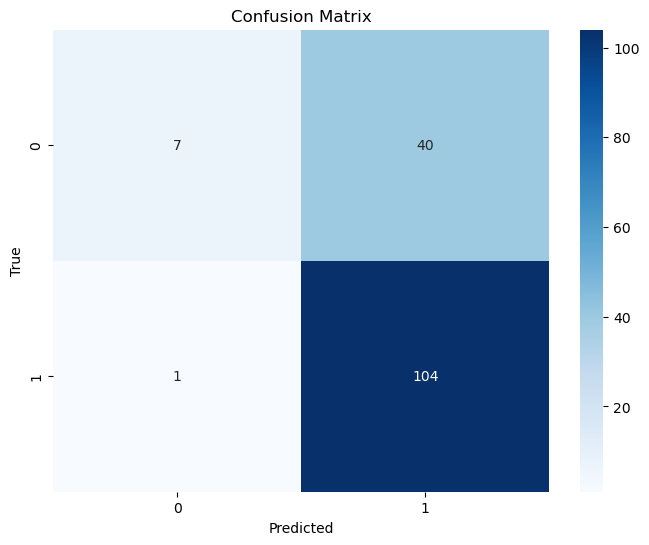

In [136]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# 计算混淆矩阵
conf_matrix = confusion_matrix(y_test, y_pred)

# 可视化混淆矩阵
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
